In [ ]:
!pip install -r requirements.txt -q

In [8]:
import gymnasium as gym
import torch
import numpy as np
import torch.nn as nn
import random
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import pickle
import wandb

##  Hyperparameters  ##

In [9]:
environment = "ALE/Breakout-v5"
bs = 32
replay_memory_size= 400_000 #replay memory max size
sync_every_n_steps = 10_000
gamma = 0.99
lr=0.0000625
epsilon = 1
final_epsilon = 0.1,
loss_fn = nn.SmoothL1Loss()
Optimizer = torch.optim.Adam
replay_start_size = 50_000
FRAMES_TO_TRAIN = 10_000_000
EPOCH_SIZE = 50_000
BASE_MODEL = None
final_exploration_frame = 1_000_000
MIN_STACK_SIZE = 4
max_grad_norm = 10
adam_epsilon = 1.5e-4
replay_period = 4

In [10]:
config = {
    "learning_rate": lr,
    "architecture": "DQN-Deepmind-2015",
    "environment": environment,
    "epsilon": epsilon,
    "final_epsilon": final_epsilon,
    "gamma":gamma,
    "bs":bs,
    "replay_memory_size":replay_memory_size,
    "sync_every_n_steps": sync_every_n_steps,
    "loss": str(loss_fn),
    "Optimizer": Optimizer.__name__,
    "frames_to_train": FRAMES_TO_TRAIN,
    "epoch_size":EPOCH_SIZE,
    "base_model": BASE_MODEL,
    "final_exploration_frame":final_exploration_frame,
    "replay_start_size":replay_start_size,
    "max_grad_norm":max_grad_norm,
    "adam_epsilon":adam_epsilon,
    "replay_period":replay_period
    }

### Optionally set up logging to wandb

In [57]:
#wandb.init(
    # set the wandb project where this run will be logged
#    project="breakout2015",
    
    # track hyperparameters and run metadata
#    config=config
#)

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


## We need an enviroment that our agant can interact with. Here we are just wrapping the gym enviroment with some extra functionality:
1. We are ensuring that the pixels are processed into a 84x84x4 tensor that is fed into the network
2. We are clipping the rewards to be between -1 and 1, because the rewards can be greater that 1.
3. We are terminating the episode when the agent loses the first of it's 5 lives. This was described in the Rainbow paper [3], and my perception was that it slightly improved the perfomaance as it discouraged the agent from going for the for the high scoring bricks at the top of the screen which usually resulted in the agent losing a life.

In [47]:
class TorchEnv:
    def __init__(self, env: gym.Env, transforms=None, terminate_after_lose_life=True, image_listener=None, clip_rewards=True):
        self.env = env
        self.n_observations = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        self.transforms = transforms
        self.terminate_after_lose_life = terminate_after_lose_life
        self.image_listener = image_listener
        self.clip_rewards = clip_rewards
        

    def step(self, a):
        s, r, terminated, _, info = self.env.step(a)
        
        if self.clip_rewards:
            r = np.clip(r, -1, 1) # clip rewards between -1 and 1 as per DeepMind

        if self.image_listener:
            self.image_listener(s)

        # terminate if we lose a life as per Rainbow
        # https://arxiv.org/pdf/1710.02298.pdf
        if self.lives != info['lives'] and self.terminate_after_lose_life:
            terminated = True
        
        if self.transforms:
            s = s[None, :, :, :] # HWC -> BCHW
            s = self.transforms(s)
        return s, r, terminated

    def reset(self, *args, **kwargs):
        s, info = self.env.reset(*args, **kwargs)
        if self.image_listener:
            self.image_listener(s)
        self.lives = info['lives']
    
        # at episode start, repeat and stack the first state 4 times
        stack = [s]
        stack = np.vstack([s[None, :, :, :]] * MIN_STACK_SIZE) # HWC -> BHWC
        
        if self.transforms:
            stack = self.transforms(stack)
        
        return stack

    def close(self):
        return self.env.close()
    
    def sample(self):
        return np.random.randint(self.n_actions)


### Preprocessing
The preprocessing steps are:
1. Convert the image to grayscale
2. Downsample the image
3. Crop the image to the play area
4. Convert the image to a pytorch tensor and load it onto the GPU if available
5. Stack the last 4 frames into a single tensor


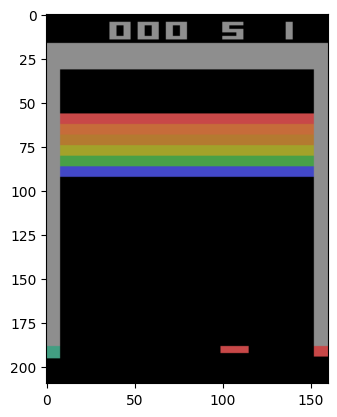

In [22]:
env = TorchEnv(gym.make(environment))
stack = env.reset() 
plt.imshow(stack[1])

#### Greyscale

In [23]:
class BatchGrayscale:
    def __init__(self):
        self.transforms = transforms.Grayscale()

    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, H, W, C)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        grey_pt_stack = torch.stack([self.transforms(s.permute(2,0,1)) for s in batch])
        return grey_pt_stack

In [24]:
def imglistshow(v_slice):
    plt.figure()
    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(nrows=1, ncols=4)
    
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    for i, image in enumerate(v_slice):
        axarr[i].axis("off")
        axarr[i].imshow(image)

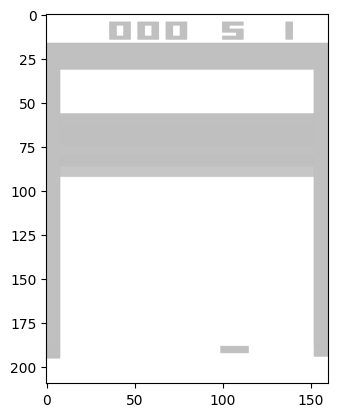

In [25]:
greyscale = BatchGrayscale() #transforms to grayscale
pt_stack = torch.from_numpy(stack).to(device)
img_stack = greyscale(pt_stack)
plt.imshow(img_stack.squeeze(1).permute(1, 2, 0))

In [26]:
class BatchDownsample:
    def __init__(self, size=(110,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        orig_dtype = batch.dtype
        result = nn.functional.interpolate(batch.float(), size=self.size,  mode='bilinear')
        return result.type(orig_dtype)

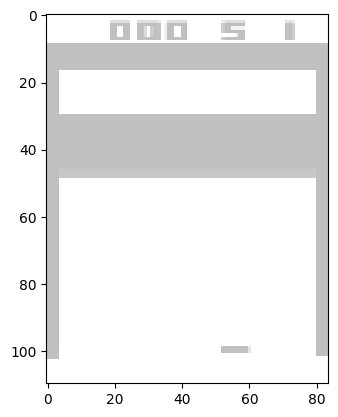

In [27]:
batch_downsample = BatchDownsample(size=(110,84))
downsampled_stack = batch_downsample(img_stack)
plt.imshow(downsampled_stack.squeeze(1).permute(1, 2, 0))

In [28]:
class BatchCrop:
    def __init__(self, size=(84,84)):
        self.size = size
    
    def __call__(self, batch: torch.Tensor):
        """ crop 17 pixels from top and bottom
        Args:
            batch (torch.Tensor): expects batch to be of shape (B, C, H, W)
        Returns:
            torch.Tensor: batch of shape (B, C, H, W)
        """
        return batch[:, :,  17:17+self.size[0], :] # crop 17 pixels from top and bottom

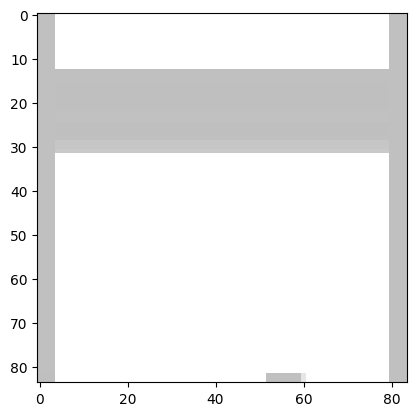

In [29]:
batch_downsample = BatchCrop(size=(84,84))
batch_downsample = batch_downsample(downsampled_stack)
plt.imshow(batch_downsample.squeeze(1).permute(1, 2, 0))

In [30]:
class BatchToTensor:
    def __init__(self, device):
        self.device = device

    def __call__(self, batch: np.array):
        """
        Args:
            batch (np.array): expects a numpy array
        Returns:
            torch.Tensor: torch tensor on device
        """
        return torch.from_numpy(batch).to(self.device)

Make a simple class that can chain together multiple transforms

In [31]:
class TransformPipeline:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, batch: torch.Tensor):
        for transform in self.transforms:
            batch = transform(batch)
        return batch

In [32]:
pipeline = TransformPipeline([BatchToTensor(device), BatchGrayscale(), BatchDownsample(), BatchCrop()])

## Experience Replay
here we fill the replay memory with downsampled cropped stacks

In [33]:
class ExperienceReplay:
    def __init__(self, maxlen: int) -> None:
        self.deque = deque(maxlen=maxlen)
        self.maxlen = maxlen

    def append(self, x: tuple)-> None:
        self.deque.append(x)

    def sample(self, bs: int) -> list:
        return random.sample(self.deque, min(len(self), bs))

    def __len__(self) -> int:
        return len(self.deque)
    
    @classmethod
    def load(cls, path: str):
        with open(path, 'rb') as f:
            return pickle.load(f)
        
    def save(self, path: str):
        with open(path, 'wb') as f:
            return pickle.dump(self, f)

def fill(replay_memory:ExperienceReplay, env:TorchEnv, fill_size:int = replay_start_size) -> None :
    while len(replay_memory)<fill_size:
        s = env.reset()
        terminated=False
        while terminated == False and len(replay_memory)<fill_size:
            a = env.sample()
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            s = s_prime

In [34]:
env = TorchEnv(gym.make(environment), transforms=pipeline)
replay_memory = ExperienceReplay(replay_memory_size)
fill(replay_memory, env, fill_size=10)
samples = replay_memory.sample(3)
s, a, r, s_prime, terminated = samples[0]
s.shape

torch.Size([4, 1, 84, 84])

<Figure size 640x480 with 0 Axes>

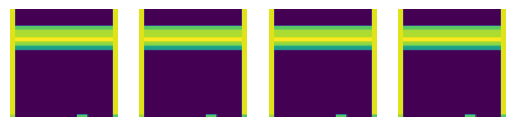

In [35]:
imglistshow(s.squeeze(1).cpu())

## Define the 2015 Atari DQN

In [36]:
class DQNDeepmind2015(nn.Module):
    def __init__(self, n_actions):
        super(DQNDeepmind2015, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
        
    def forward(self, s):
        return self.conv(s) 

In [37]:
class AtariDQN(nn.Module):
    def __init__(self, net, n_actions, normalize=True):
        super(AtariDQN, self).__init__()
        self.net = net
        self.n_actions = n_actions
        self.normalize = normalize

    def forward(self, s: torch.Tensor):
        '''
        Args:
            s (torch.Tensor): batch of shape (B, H, W)
        Returns:
            torch.Tensor: batch of shape (B, n_actions)
        '''
        if self.normalize:
            s = s.float() / 255.0
        return self.net(s)

    def select_next_action(self, s, epsilon):
        with torch.no_grad():
            use_greedy = np.random.binomial(1, 1-epsilon)
            if use_greedy:
                a = self(s).argmax().item()
            else:
                a = np.random.randint(self.n_actions)
            return a

# Train Network
Create the model and the target network. You can optionally load a pretrained model here by providing a path to the model in the BASE_MODEL variable.

In [40]:
dqn = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
if BASE_MODEL is not None:
    print(f"Loading base model from {BASE_MODEL}")
    dqn.load_state_dict(torch.load(BASE_MODEL))


### Iniitalize the target network

In [41]:
target_net = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
target_net.load_state_dict(dqn.state_dict())

<All keys matched successfully>

Define some functions that will be used to train the network

In [42]:
def atari_collate(batch):
    s_j, a_j, r_j, s_prime_j, terminated_j = list(zip(*batch))
    return (torch.stack(s_j).squeeze(2).to(device), 
            torch.tensor(a_j).to(device), 
            torch.tensor(r_j).to(device), 
            torch.stack(s_prime_j).squeeze(2).to(device), 
            (~torch.tensor(terminated_j)).to(device).half()
    )
def get_batch_efficient(self, batch, target_net, collate_fn=None):
    s, a, r, s_prime, not_terminated = collate_fn(batch)

    y_hat = self(s).gather(1, a.unsqueeze(1)).squeeze() # gather the values at the indices given by the actions a

    with torch.no_grad():
        next_values, _ = target_net(s_prime).max(dim=1) # IMPORTANT: we're using the target network here
        next_values = next_values.clone().detach()

    #Bellman equation... our target
    y_j = r.detach().clone() + gamma * next_values * not_terminated # if terminated then not_terminated is set to zero (y_j = r)
    return y_hat, y_j

def get_epsilon(epsilon, final_epsilon=0.1, steps_to_anneal=final_exploration_frame):
    if epsilon > final_epsilon:
        epsilon -= (1/steps_to_anneal) * (1-final_epsilon)
    return epsilon

Define a validation functino that will run episodes in a 5 minute period and return the average score. Note that we also create a new environment that doesn't clip the rewards or terminate the episode when the agent loses a life, as this ensures that we get a true measure of the agents score in the game.

In [43]:
def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.1)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

val_env = TorchEnv(gym.make(environment), transforms=pipeline, terminate_after_lose_life=False, clip_rewards=False)
validate(dqn, val_env)

0.11290322580645161

Training loop.
1. We are only training every 4th frame as specified by the replay_period. 
2. We sync the target network with the model every 10000 frames as specified by the sync_every_n_steps
3. You can optionally log to wandb by uncommenting the wandb lines

In [344]:
optimizer = Optimizer(dqn.parameters(),  lr=lr, eps=adam_epsilon)
dqn.train()
n_epochs = FRAMES_TO_TRAIN // EPOCH_SIZE
print(n_epochs)
track = True
for epoch in range(n_epochs):
    epoch_loss, epoch_reward, k, epoch_episodes = 0, 0, 0, 0
    while k < EPOCH_SIZE:
        terminated = False
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), epsilon)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            replay_memory.append((s, a, r, s_prime, terminated))
            epsilon = get_epsilon(epsilon)
            s = s_prime

            if len(replay_memory) > replay_start_size and k % replay_period == 0:
                optimizer.zero_grad()
                batch = replay_memory.sample(bs)
                y_hat, y = get_batch_efficient(dqn, batch, target_net=target_net, collate_fn=atari_collate)
                loss = loss_fn(y_hat, y)
                loss.backward()
                torch.nn.utils.clip_grad_value_(dqn.parameters(), max_grad_norm)
                optimizer.step()
                        
                if k % sync_every_n_steps == 0:
                    target_net.load_state_dict(dqn.state_dict())
            
                loss = loss.detach()
                epoch_loss += loss.item()
            epoch_reward += r
            k += 1
        epoch_episodes += 1
    
    if track:
        validate_reward = validate(dqn, env)
        torch.save(dqn.state_dict(), 'breakout2015.pt')
        #wandb.log_model(name=f"breakout2015-{wandb.run.id}", path='breakout2015.pt')
        #wandb.log({"epoch":epoch,
        #        "step_loss": epoch_loss / k, 
        #        "reward": epoch_reward / epoch_episodes,
        #        "step":k,
        #        "epsilon": epsilon,
        #        "validate_reward":validate_reward
        #        })
        print(f'epochs {epoch}, step_loss {epoch_loss / k}, reward {epoch_reward / epoch_episodes}, validate_reward {validate_reward}, k {k}, epsilon {epsilon}')
env.close()

200

In [ ]:
wandb.finish()

### Validation

Define a simple class that will keep track of the frames as the agent steps through the environment.

In [53]:
class ImageListener:
    def __init__(self, name):
        self.name = name
        self.images = []

    def __call__(self, img):
        self.images.append(img)

image_listener = ImageListener("breakout2015")

In [54]:
MODEL_FILE_PATH = 'breakout2015.pt'
env = TorchEnv(gym.make(environment), transforms=pipeline, terminate_after_lose_life=False, clip_rewards=False, image_listener=image_listener)
dqn = AtariDQN(DQNDeepmind2015(env.n_actions).to(device), n_actions=env.n_actions).to(device)
dqn.load_state_dict(torch.load(MODEL_FILE_PATH, map_location=torch.device('cpu')))


<All keys matched successfully>

In [55]:

def validate(dqn, env):
    k = 0
    total_rewards = []
    while k < 15*60*5: #15 frames / sec * 60 seconds * 5 minutes
        terminated = False
        rewards = 0
        s = env.reset()
        while terminated == False:
            a = dqn.select_next_action(s.squeeze(1).unsqueeze(0), 0.05)
            s_prime, r, terminated = env.step(a)
            s_prime = torch.cat([s, s_prime])[-4:]
            s = s_prime
            rewards += r
            k += 1
        total_rewards.append(rewards)
    return sum(total_rewards)/len(total_rewards)

validate(dqn, env)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


45.0

Save the validation images to a np4 video file

In [51]:
from video import WRITERS

In [ ]:
WRITERS["opencv"](iter(image_listener.images), f"{MODEL_FILE_PATH}.mp4")